In [2]:
pip install sentence-transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
df = pd.read_csv('/content/Tweets.csv')

In [6]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
cat_id = {'neutral':1,
         'negative':0,
         'positive':2}

In [8]:
df['class'] = df['sentiment'].map(cat_id)

In [9]:
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [10]:
df = df.dropna()

In [11]:
BATCH_SIZE=512
NUM_EPOCHS=80

X = df['text'].values
Y = df['class'].values

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5,random_state=123)

In [12]:
ohe = CountVectorizer()
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

In [13]:
class SentimentData(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.Y = torch.Tensor(Y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [14]:
train_ds = SentimentData(X=X_train_ohe, Y=Y_train)
test_ds = SentimentData(X=X_test_ohe, Y=Y_test)

In [15]:
BATCH_SIZE = 512
NUM_EPOCHS=80
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [16]:
class SentimentModel(nn.Module):
    def __init__(self,NUM_FEATURES,NUM_CLASSES,HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES,HIDDEN)
        self.linear2 = nn.Linear(HIDDEN,NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [17]:
model = SentimentModel(NUM_FEATURES = X_train_ohe.shape[1],NUM_CLASSES=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [18]:
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch,Y_batch in train_loader:
        optimizer.zero_grad()
        Y_pred_log = model(X_batch)
        loss = criterion(Y_pred_log,Y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(curr_loss)
    print(f'Epochs : {e} , Loss : {curr_loss}')

Epochs : 0 , Loss : 29.320378184318542
Epochs : 1 , Loss : 27.942328929901123
Epochs : 2 , Loss : 26.261286973953247
Epochs : 3 , Loss : 24.382672607898712
Epochs : 4 , Loss : 22.499562859535217
Epochs : 5 , Loss : 20.711011230945587
Epochs : 6 , Loss : 19.096446931362152
Epochs : 7 , Loss : 17.645996153354645
Epochs : 8 , Loss : 16.359429717063904
Epochs : 9 , Loss : 15.225603342056274
Epochs : 10 , Loss : 14.209992915391922
Epochs : 11 , Loss : 13.299423217773438
Epochs : 12 , Loss : 12.491656929254532
Epochs : 13 , Loss : 11.75392296910286
Epochs : 14 , Loss : 11.096604198217392
Epochs : 15 , Loss : 10.492127448320389
Epochs : 16 , Loss : 9.954921513795853
Epochs : 17 , Loss : 9.448612064123154
Epochs : 18 , Loss : 9.003618359565735
Epochs : 19 , Loss : 8.580096364021301
Epochs : 20 , Loss : 8.1926589012146
Epochs : 21 , Loss : 7.835011541843414
Epochs : 22 , Loss : 7.500225245952606
Epochs : 23 , Loss : 7.194577291607857
Epochs : 24 , Loss : 6.893943801522255
Epochs : 25 , Loss : 6

<Axes: >

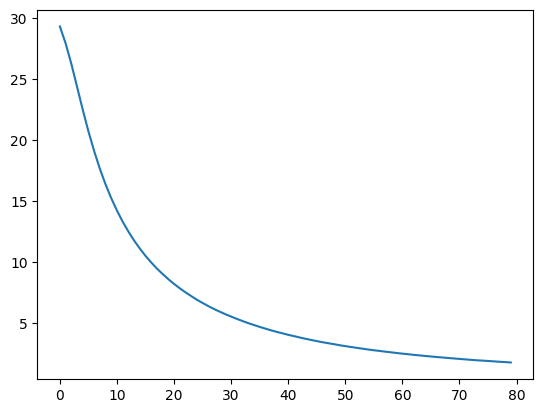

In [19]:
sns.lineplot(x=list(range(len(train_losses))),y=train_losses)

In [20]:
with torch.no_grad():
    for X_batch,Y_batch in test_loader:
        Y_test_pred_log = model(X_batch)
        Y_test_pred = torch.argmax(Y_test_pred_log,dim=1)

In [21]:
Y_test_pred_np = Y_test_pred.squeeze().cpu().numpy()
acc = accuracy_score(y_pred = Y_test_pred_np,y_true = Y_test)
f"The accuracy is : {np.round(acc,3)*100}%"

'The accuracy is : 63.3%'

In [22]:
most_common_cnt = Counter(Y_test).most_common()[0][1]
print(f"Naive Classifier : {np.round(most_common_cnt / len(Y_test) * 100 , 1)} %")

Naive Classifier : 41.0 %


<Axes: >

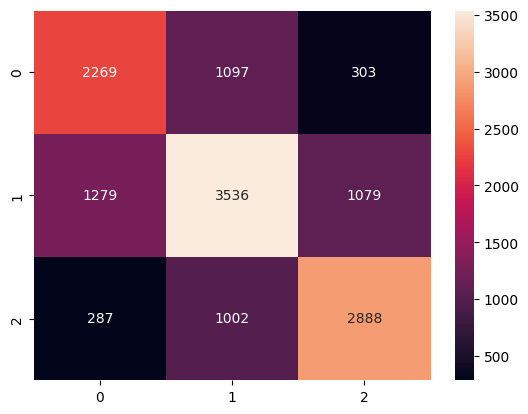

In [23]:
sns.heatmap(confusion_matrix(Y_test_pred_np,Y_test),annot=True,fmt=".0f")

**GLOVE - GLOBAL VECTOR REPRESENTATION**

In [24]:
import torch
import torchtext
import torchtext.vocab as vocab
torchtext.disable_torchtext_deprecation_warning()

/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [25]:
glove_dim = 100
glove = vocab.GloVe(name='6B',dim=100)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:37<00:00, 10574.12it/s]


In [26]:
glove.vectors.shape

torch.Size([400000, 100])

In [27]:
glove.stoi['woman']

787

In [28]:
glove.itos[787]

'woman'

In [29]:
def get_embedding_vector(word):
    word_index = glove.stoi[word]
    emb = glove.vectors[word_index]
    return emb

In [30]:
get_embedding_vector('chess').shape

torch.Size([100])

In [31]:
def get_close_words_from_word(word,max_n=5):
    word_emb = get_embedding_vector(word)
    distances = [(w,torch.dist(word_emb,get_embedding_vector(w)).cpu().item()) for w in glove.itos]
    dist_sort = sorted(distances,key=lambda x: x[1])[:max_n]
    return dist_sort

In [32]:
get_close_words_from_word('chess')

[('chess', 0.0),
 ('backgammon', 4.379469394683838),
 ('grandmasters', 4.56368350982666),
 ('grandmaster', 4.613785743713379),
 ('scrabble', 4.677640438079834)]

In [33]:
def get_close_words_from_embedding(word_emb,max_n=5):
    distances = [(w,torch.dist(word_emb,get_embedding_vector(w)).cpu().item()) for w in glove.itos]
    dist_sort = sorted(distances,key=lambda x: x[1])[:max_n]
    return dist_sort

In [34]:
def get_word_analogy(word1,word2,word3,n=5):
  word1_emb = get_embedding_vector(word1)
  word2_emb = get_embedding_vector(word2)
  word3_emb = get_embedding_vector(word3)
  word4_emb = word1_emb - word2_emb + word3_emb
  analogy = get_close_words_from_embedding(word4_emb)
  return analogy

In [35]:
get_word_analogy('man','king','woman')

[('woman', 5.803607940673828),
 ('man', 6.803570747375488),
 ('girl', 7.174243450164795),
 ('person', 7.643591403961182),
 ('victim', 7.720379829406738)]

**GLOVE WORDCLUSTER**

In [36]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.manifold import TSNE

In [37]:
words = []
categories = ['numbers','algebra','music','science','technology']

df_word_cloud = pd.DataFrame({
    'category':[],
    'word':[]
})

In [38]:
for category in categories:
    print(category)
    closest_words = get_close_words_from_word(category, max_n=20)
    temp = pd.DataFrame({
        'category': [category] * len(closest_words),
        'word': closest_words
    })

    df_word_cloud = pd.concat([df_word_cloud, temp], ignore_index=True)

numbers
algebra
music
science
technology


In [39]:
closest_words

[('technology', 0.0),
 ('technologies', 3.3375868797302246),
 ('tech', 4.250084400177002),
 ('innovation', 4.4075798988342285),
 ('computer', 4.408792972564697),
 ('technological', 4.472376823425293),
 ('systems', 4.6043925285339355),
 ('computing', 4.637466907501221),
 ('software', 4.646875858306885),
 ('communication', 4.690243721008301),
 ('engineering', 4.716692924499512),
 ('business', 4.7505998611450195),
 ('developed', 4.817268371582031),
 ('development', 4.8343963623046875),
 ('industry', 4.873386859893799),
 ('applications', 4.896607398986816),
 ('innovations', 4.897731781005859),
 ('developing', 4.898324012756348),
 ('research', 4.9329142570495605),
 ('integrated', 4.941524982452393)]

In [40]:
df_word_cloud

,category,word
0,numbers,"(numbers, 0.0)"
1,numbers,"(number, 3.4887592792510986)"
2,numbers,"(though, 4.128623962402344)"
3,numbers,"(instance, 4.160089492797852)"
4,numbers,"(fact, 4.180027484893799)"
...,...,...
95,technology,"(applications, 4.896607398986816)"
96,technology,"(innovations, 4.897731781005859)"
97,technology,"(developing, 4.898324012756348)"
98,technology,"(research, 4.9329142570495605)"


In [41]:
glove_dim = 100
n_rows = df_word_cloud.shape[0]
n_cols = glove_dim
X = torch.empty((n_rows,n_cols))

for category in categories:
    print(category)
    closest_words = get_close_words_from_word(category, max_n=20)

    closest_words = [word for word, _ in closest_words]
    temp = pd.DataFrame({
        'category': [category] * len(closest_words),
        'word': closest_words
    })

    df_word_cloud = pd.concat([df_word_cloud, temp], ignore_index=True)

numbers
algebra
music
science
technology


In [42]:
df_word_cloud

,category,word
0,numbers,"(numbers, 0.0)"
1,numbers,"(number, 3.4887592792510986)"
2,numbers,"(though, 4.128623962402344)"
3,numbers,"(instance, 4.160089492797852)"
4,numbers,"(fact, 4.180027484893799)"
...,...,...
195,technology,applications
196,technology,innovations
197,technology,developing
198,technology,research


In [43]:
X

tensor([[ 5.4966e+32,  4.4120e-41,  5.5016e+32,  ...,  4.4120e-41,
          5.1630e+32,  4.4120e-41],
        [ 1.1622e+22,  4.4120e-41,  1.1622e+22,  ...,  4.4117e-41,
         -6.1686e+08,  4.4117e-41],
        [-1.0773e+11,  4.4117e-41,  5.2502e+32,  ...,  4.4117e-41,
          5.5016e+32,  4.4120e-41],
        ...,
        [-1.2902e+10,  4.4117e-41, -1.5222e+10,  ...,  4.4117e-41,
         -9.5527e+09,  4.4117e-41],
        [-4.9937e+09,  4.4117e-41, -1.5755e+10,  ...,  4.4117e-41,
         -4.9685e+09,  4.4117e-41],
        [-3.0921e+10,  4.4117e-41, -5.3039e+08,  ...,  4.4117e-41,
         -8.7404e+09,  4.4117e-41]])

In [44]:
tsne = TSNE(n_components=2)
X_np = X.cpu().numpy()
X_tsne = tsne.fit_transform(np.nan_to_num(X_np)) # Replace NaNs with zeros

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:631: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:636: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:640: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_pca.py:644: RuntimeWarning: invalid value encountered in scalar subtract
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply


In [45]:
print(df_word_cloud.shape[0])
print(X_tsne.shape)

200
(100, 2)


In [46]:
df_word_cloud_subset = df_word_cloud.iloc[:X_tsne.shape[0]].copy()

In [47]:
df_word_cloud_subset['x'] = X_tsne[:, 0]
df_word_cloud_subset['y'] = X_tsne[:, 1]

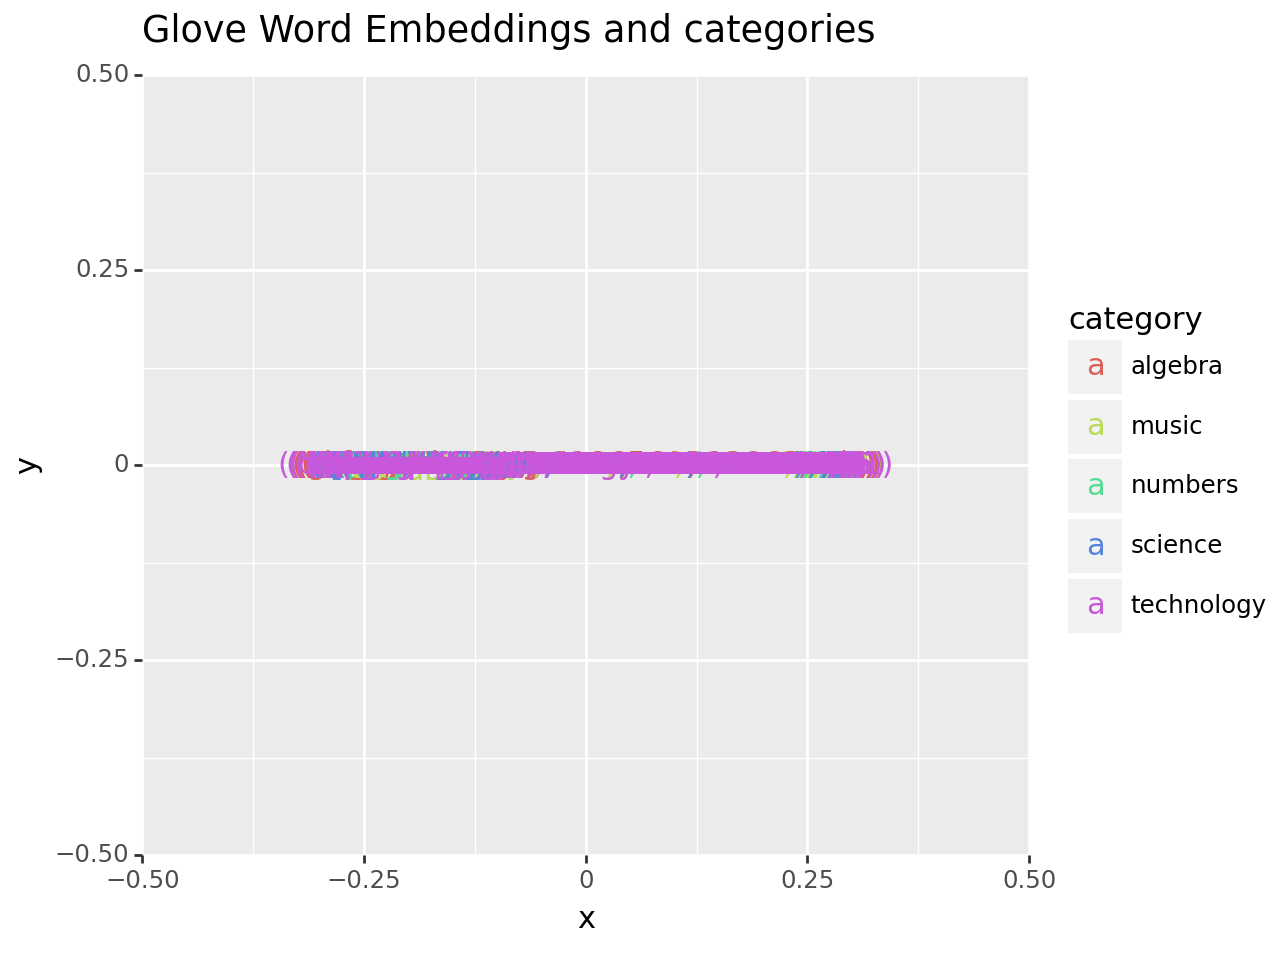

<Figure Size: (640 x 480)>

In [48]:
ggplot(data=df_word_cloud_subset,
       mapping=aes(x='x', y='y', label='word', color='category')) + \
    geom_text() + \
    labs(title='Glove Word Embeddings and categories')

**SENTIMENT EMBEDDING**

In [48]:
df = pd.read_csv('/content/Tweets.csv').dropna()

In [49]:
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [50]:
cat_id = {'neutral':1,
         'negative':0,
         'positive':2}

In [51]:
df['class'] = df['sentiment'].map(cat_id)

In [52]:
BATCH_SIZE=128
NUM_EPOCHS=10
MAX_FEATURES = 10

In [53]:
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [54]:
sentences = ["Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

(768,)


In [55]:
X = emb_model.encode(df['text'].values)
Y = df['class'].values

In [56]:
import pickle
with open("tweets_X.pkl","wb") as f:
  pickle.dump(X,f)

In [57]:
with open("tweets_X.pkl","rb") as f:
  X = pickle.load(f)

In [58]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5,random_state=123)

In [61]:
class SentimentData(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X = torch.Tensor(X) # Remove .toarray() as it's a numpy array
        self.Y = torch.Tensor(Y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [62]:
train_ds = SentimentData(X=X_train, Y=Y_train)
test_ds = SentimentData(X=X_test, Y=Y_test)

In [63]:
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [64]:
class SentimentModel(nn.Module):
    def __init__(self,NUM_FEATURES,NUM_CLASSES,HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES,HIDDEN)
        self.linear2 = nn.Linear(HIDDEN,NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [67]:
model = SentimentModel(NUM_FEATURES = 768, NUM_CLASSES=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [68]:
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch,Y_batch in train_loader:
        optimizer.zero_grad()
        Y_pred_log = model(X_batch)
        loss = criterion(Y_pred_log,Y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_losses.append(curr_loss)
    print(f'Epochs : {e} , Loss : {curr_loss}')

Epochs : 0 , Loss : 111.84276616573334
Epochs : 1 , Loss : 91.06554436683655
Epochs : 2 , Loss : 81.88093078136444
Epochs : 3 , Loss : 78.36253619194031
Epochs : 4 , Loss : 76.57414448261261
Epochs : 5 , Loss : 75.40009707212448
Epochs : 6 , Loss : 74.61478465795517
Epochs : 7 , Loss : 73.9884957075119
Epochs : 8 , Loss : 73.33037281036377
Epochs : 9 , Loss : 72.76910835504532


<Axes: >

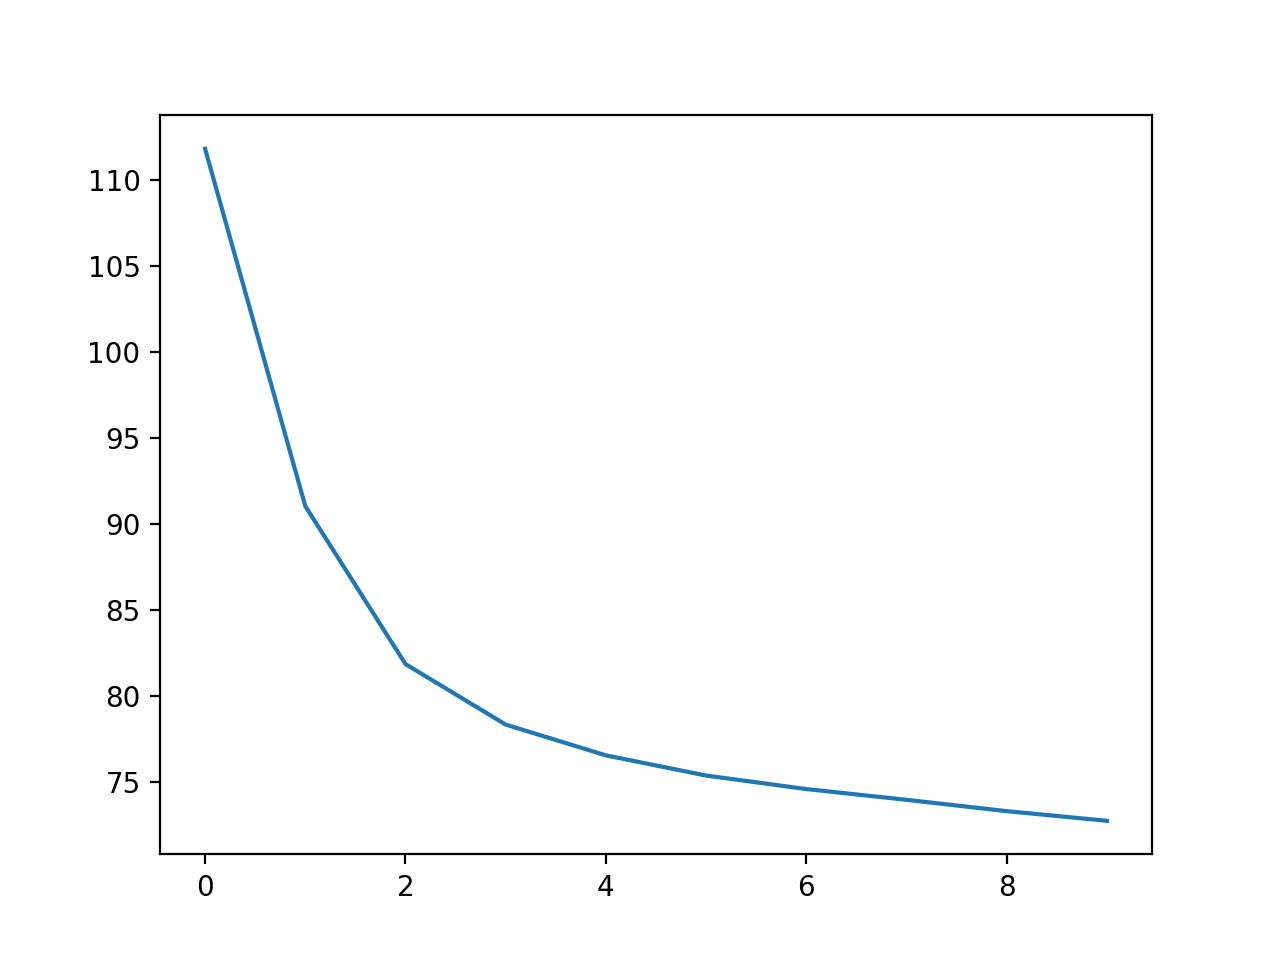

In [69]:
sns.lineplot(x=list(range(len(train_losses))),y=train_losses)

In [70]:
with torch.no_grad():
    for X_batch,Y_batch in test_loader:
        Y_test_pred_log = model(X_batch)
        Y_test_pred = torch.argmax(Y_test_pred_log,dim=1)

In [71]:
Y_test_pred_np = Y_test_pred.squeeze().cpu().numpy()
acc = accuracy_score(y_pred = Y_test_pred_np,y_true = Y_test)
f"The accuracy is : {np.round(acc,3)*100}%"

'The accuracy is : 67.9%'